In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


### Data preparation

#### Reading data

In [2]:
df = pd.read_csv('../data/emotions/emotions.csv')

In [3]:
df['category'] = df['category'].str.strip()

In [4]:
df.shape

(35887, 2307)

In [5]:
train = df.loc[df.category == 'Training',:]
valid = df.loc[df.category == 'PublicTest',:]
test  = df.loc[df.category == 'PrivateTest',:]

In [6]:
train.head(5)

,Unnamed: 0,y,0,1,2,3,4,5,6,7,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,category
0,0,0,70,80,82,72,58,58,60,63,...,182,183,136,106,116,95,106,109,82,Training
1,1,0,151,150,147,155,148,133,111,140,...,108,95,108,102,67,171,193,183,184,Training
2,2,2,231,212,156,164,174,138,161,173,...,138,152,122,114,101,97,88,110,152,Training
3,3,4,24,32,36,30,32,23,19,20,...,126,132,132,133,136,139,142,143,142,Training
4,4,6,4,0,0,0,0,0,0,0,...,34,31,31,31,27,31,30,29,30,Training


In [7]:
X_train = np.array(train.iloc[:, 2:2306])
print(X_train)
X_train = (X_train.T-X_train.mean(axis=1)).T
print(X_train)
y_train = np.array(train.loc[:, ['y']])

print(X_train.shape)
print(y_train.shape)

[[ 70  80  82 ... 106 109  82]
 [151 150 147 ... 193 183 184]
 [231 212 156 ...  88 110 152]
 ...
 [ 74  81  87 ... 188 187 187]
 [222 227 203 ... 136 136 134]
 [195 199 205 ...   6  15  38]]
[[ -47.59288194  -37.59288194  -35.59288194 ...  -11.59288194
    -8.59288194  -35.59288194]
 [  24.02864583   23.02864583   20.02864583 ...   66.02864583
    56.02864583   57.02864583]
 [  70.18576389   51.18576389   -4.81423611 ...  -72.81423611
   -50.81423611   -8.81423611]
 ...
 [ -69.50043403  -62.50043403  -56.50043403 ...   44.49956597
    43.49956597   43.49956597]
 [  84.15451389   89.15451389   65.15451389 ...   -1.84548611
    -1.84548611   -3.84548611]
 [  20.79730903   24.79730903   30.79730903 ... -168.20269097
  -159.20269097 -136.20269097]]
(28709, 2304)
(28709, 1)


In [8]:
X_val = np.array(valid.iloc[:, 2:2306])
X_val = (X_val.T-X_val.mean(axis=1)).T
y_val = np.array(valid.loc[:, ['y']])

print(X_val.shape)
print(y_val.shape)

(3589, 2304)
(3589, 1)


In [9]:
X_test = np.array(test.iloc[:, 2:2306])
X_test = (X_test.T-X_test.mean(axis=1)).T
y_test = np.array(test.loc[:, ['y']])

print(X_test.shape)
print(y_test.shape)

(3589, 2304)
(3589, 1)


#### Define mapping from labels to their names

In [10]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

#### Display some random images

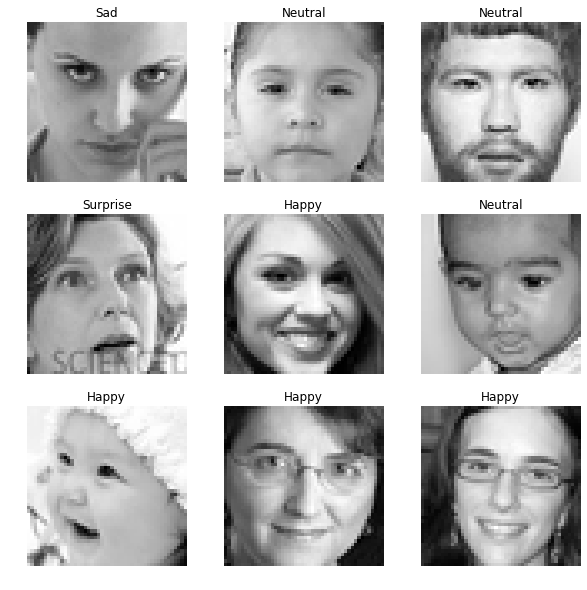

In [11]:
np.random.seed(1)

fig = plt.figure(figsize=(10, 10))

rows = 3
cols = 3

for i in range(1, rows * cols + 1):
    idx = np.random.randint(1, len(X_train))
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(X_train[idx].reshape((48,48)), cmap = 'gray')
    plt.title(mapping[y_train[idx][0]])
    plt.axis('off')
plt.show()

In [12]:
y_train = keras.utils.to_categorical(y_train, 7)
y_train.shape

(28709, 7)

In [13]:
y_val = keras.utils.to_categorical(y_val, 7)
y_val.shape

(3589, 7)

In [14]:
y_test = keras.utils.to_categorical(y_test, 7)
y_test.shape

(3589, 7)

#### Displaying total counts of different labels

In [15]:
import collections
dict(collections.Counter(np.array(train.loc[:, ['y']])[:,0]))

{0: 3995, 2: 4097, 4: 4830, 6: 4965, 3: 7215, 5: 3171, 1: 436}

### VGG Model

In [16]:
from keras.models import Sequential
from keras.optimizers import SGD,Adadelta
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU
import keras

np.random.seed(100)

#### Reshape samples

In [17]:
X_train_r = X_train.reshape((len(X_train), 48, 48, 1))
X_val_r   = X_val.reshape((len(X_val), 48, 48, 1))
X_test_r   = X_test.reshape((len(X_test), 48, 48, 1))

#### Normalize data

In [18]:
X_train_r = X_train_r / 255

In [19]:
X_val_r = X_val_r / 255

In [20]:
X_test_r = X_test_r / 255

In [22]:
X_train_r.shape

(28709, 48, 48, 1)

#### Define the model

In [23]:
img_rows, img_cols = 48, 48
model = Sequential()
model.add(Conv2D(64, (3, 3), name='block1_conv1', activation='relu', padding="same",
                        input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(64, (3, 3), name='block1_conv2', activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'))
          
model.add(Conv2D(128, (3, 3), name='block2_conv1', activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), name='block2_conv2', activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'))

model.add(Conv2D(256, (3, 3), name='block3_conv1', activation='relu', padding="same"))
model.add(Conv2D(256, (3, 3), name='block3_conv2', activation='relu', padding="same"))
model.add(Conv2D(256, (3, 3), name='block3_conv3', activation='relu', padding="same"))
model.add(Conv2D(256, (3, 3), name='block3_conv4', activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'))
          
model.add(Conv2D(512, (3, 3), name='block4_conv1', activation='relu', padding="same"))
model.add(Conv2D(512, (3, 3), name='block4_conv2', activation='relu', padding="same"))
model.add(Conv2D(512, (3, 3), name='block4_conv3', activation='relu', padding="same"))
model.add(Conv2D(512, (3, 3), name='block4_conv4', activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'))
          
model.add(Conv2D(512, (3, 3), name='block5_conv1', activation='relu', padding="same"))
model.add(Conv2D(512, (3, 3), name='block5_conv2', activation='relu', padding="same"))
model.add(Conv2D(512, (3, 3), name='block5_conv3', activation='relu', padding="same"))
model.add(Conv2D(512, (3, 3), name='block5_conv4', activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'))
               
#model.add(GlobalAveragePooling2D())

model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax', name='predictions'))

ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
                  optimizer=ada,
                  metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 12, 12, 256)       295168    
__________

In [25]:
batch_size = 32
epochs = 3

In [ ]:
"Training with augmented data. Augmentation takes place while training"

from keras.preprocessing.image import ImageDataGenerator

#Generate augmented data
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

valgen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False) 

datagen.fit(X_train_r)
valgen.fit(X_val_r)
#model.load_weights('../models/weights/vgg19_other.h5')

model.fit(X_train_r, y_train, batch_size=32, epochs=3, validation_data=(X_val_r, y_val))

#Note: Given training is done using best checkpoint saved after 200 epochs



Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/3
20576/28709 [====================>.........] - ETA: 15:41 - loss: 1.8343 - acc: 0.2507

In [ ]:
model.save_weights('../models/weights/vgg19_other.h5')

In [94]:
model_json = model.to_json()

In [95]:
with open("../models/model_deep_vgg.json", "w") as json_file:
    json_file.write(model_json)

#### Data Augmentation

In [28]:
#batch_size=32

In [32]:
#from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import array_to_img, img_to_array, load_img

#gen = ImageDataGenerator(
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True
#)

#train_generator=gen.flow(x=X_train_r, 
#                         y=y_train, 
#                         batch_size=batch_size)

In [33]:
#validation_generator=gen.flow(x=X_val_r, 
#                         y=y_val, 
#                         batch_size=batch_size)

#### Iteration

In [28]:
def read_model_from_disk(model: str, weights: str):
    
    json_file = open(model, 'r')
    
    loaded_model = json_file.read()
    
    model = model_from_json(loaded_model)
    
    model.load_weights(weights)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

In [29]:
model_saved = read_model_from_disk(model='../models/model_deep.json', weights='../models/weights/complex_20_cc_2.h5')

### Evaluations

In [30]:
model_saved.evaluate(X_test_r, y = y_test, verbose=1)

3589/3589 [==============================] - 35s 10ms/step


[1.4520415713708026, 0.632488158269658]

Our baseline model gave `63%` accuracy on test dataset. In the original competition leaderboard, it would be in top 10 submissions. We think, that it is absolutely possible to get even higher accuracy by training the model for larger number of epochs.

### Investigation

In [31]:
from sklearn.metrics import confusion_matrix

During the data analysis stage of our project we understood that the primary weakness of this dataset is its inbalanceness. We haven't tackled this issue yet (plan to do it in the next iteration), but we understood that dealing with it is a major part of this particular problem solution.

Let's take a look on the accuracy of prediction of separate classes of emotions.

In [43]:
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

In [44]:
y['pred'] = model_saved.predict_classes(X_test_r)

In [45]:
y['true'] = y['true'].map(mapping)

In [46]:
y['pred'] = y['pred'].map(mapping)

In [47]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

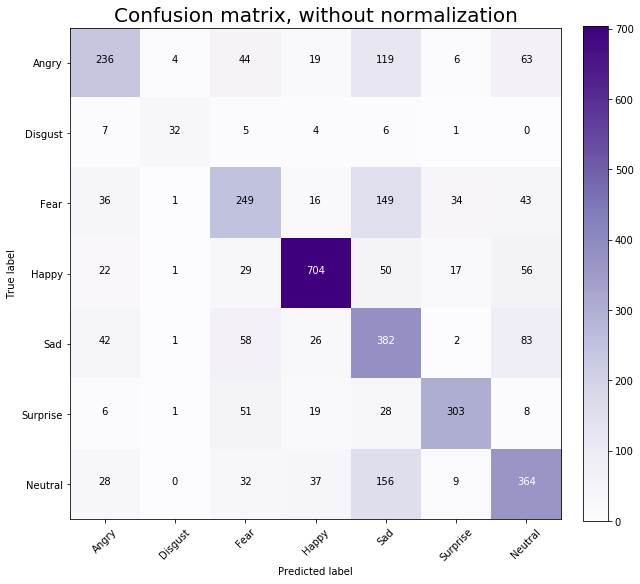

In [49]:
cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)


plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

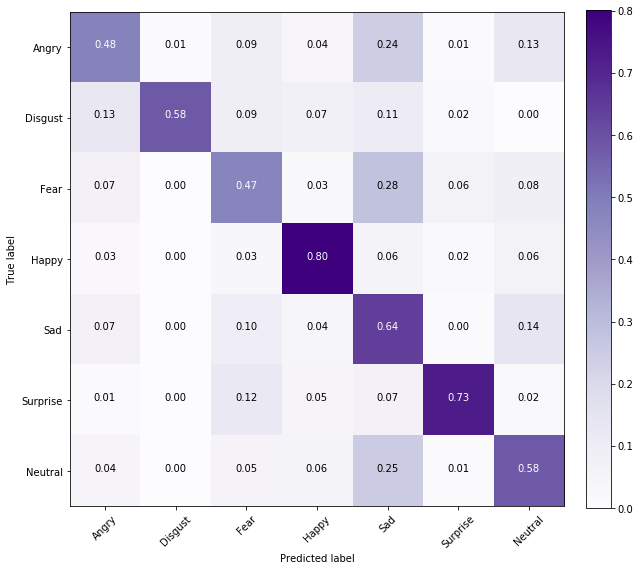

In [51]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='', cmap = 'Purples')
plt.savefig('../images/confusion.png')

Looks really funny, because we've got very unexpected results. `Disgust` emotion, while being extremely underepresented is our dataset is not the one that suffers most from misclassification.

It is `Angry` and `Fear`, that model most offen treats as other facial expression.

`Fear` ia mostly confused with `Sad`. Maybe because often when a person expreriences feat, it doesn't influence her facial expression and has impact only on some inner feelings. In general, when we are afraid of something, we can have different facial expression, depending on the situation, surrounding and the cause of fear. Fear is a complex emotion there is no single facial expression that corresponds to it.

From the confusion matrix we can conclude 3 out of 6 facial expression are often confused with `Sad`. It looks like this is the most obvious way to describe the expression if we are not sure what we see. 

One important thing should be noted here: our primary assumption that accuracy of classification of images will be smaller for underrepresented classes is not confirmed by the results produced by our model.

This fact proves once again that the problem of facial expression recognition is not as simple as it seems at first sight.